In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from matplotlib import rcParams 
rcParams.update({'font.size': 18})

In [1]:
import tensorflow as tf
import tensorflow.python.keras.backend as K
from tensorflow.python.keras.backend import eager_learning_phase_scope

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
# tf.compat.v1.disable_eager_execution()

In [2]:
tf.__version__

'2.4.1'

In [5]:
import xarray as xr
import os

/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


## Data Prep

In [ ]:
with open("../data/")

In [7]:
temp = xr.open_dataset('/srv/scratch/z3289452/OceanDataScience/Mooring/PH100/IMOS_ANMN-NSW_TZ_20091029_PH100_FV01_TEMP-aggregated-timeseries_END-20190612_C-20190819.nc')

In [8]:
temp = temp.drop(['instrument_index','instrument_id','source_file'])

In [9]:
temp = temp.where(np.logical_and(temp.TEMP_quality_control > 0, temp.TEMP_quality_control < 3), drop = True)
temp = temp.where(np.logical_and(temp.DEPTH_quality_control > 0, temp.DEPTH_quality_control < 3), drop = True)
# temp = temp.where(np.logical_and(temp.PRES_quality_control > 0, temp.PRES_quality_control < 3), drop = True)
# temp = temp.where(np.logical_and(temp.PRES_REL_quality_control > 0, temp.PRES_REL_quality_control < 3), drop = True)
len(temp.TEMP)

25290070

In [10]:
# create pd dataframe from scratch
data  = {'TIME': temp.TIME.values,
         'TEMP': temp.TEMP.values,
         'DEPTH':temp.DEPTH.values,
#          'PRES': temp.PRES.values,
#          'PRES_REL': temp.PRES_REL.values
        }

temp_df= pd.DataFrame(data, columns = ['TIME','TEMP','DEPTH'])#,'PRES','PRES_REL'])
# set TIME as the indexing variable
temp_df = temp_df.set_index('TIME')

In [11]:
temp_df.count()

TEMP     25290070
DEPTH    25290070
dtype: int64

In [12]:
# Max and min pressure values
bin_max = temp_df.DEPTH.max()
bin_min = temp_df.DEPTH.min()
bin_size = 1

In [13]:
def create_bins(bin_size, bin_max):
    """
    A function to return equal sized bins and corresponding bin labels for binning of data.
    Input:
    bin_size: size of bins
    bin_max: maximum value of the data to be binned. The minimum is assumed to be zero.
    """
    num_bins = int(np.ceil(bin_max/bin_size))
    lab_start = int(np.ceil(bin_size/2))
    bins = np.linspace(0, bin_size*num_bins, num_bins+1)
    labs = np.linspace(lab_start, bin_size*(num_bins-1)+lab_start, num_bins)
    return bins, labs

In [14]:
# Automatically calculate pressure bin parameters based on given bin_size
bins, labs = create_bins(bin_size, bin_max)
bins, labs

(array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
         66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
         77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
         88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
         99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
        110., 111., 112., 113., 114., 115.]),
 array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
         23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.

In [15]:
# create a column with pressure bin labels
temp_df['DEPTH_BIN'] = pd.cut(temp_df.DEPTH, bins = bins, labels = labs)

In [16]:
# First groupby PRES_BIN column, then resample each group on hourly intervals and mean each resulting bin
# drop unncessary columns and nan rows after
temp_df = temp_df.groupby('DEPTH_BIN').resample('1D').mean().drop(columns=['DEPTH','DEPTH_BIN']).dropna()

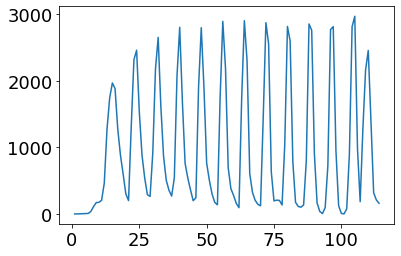

In [17]:
counts = temp_df.groupby('DEPTH_BIN').count()
plt.plot(counts)

In [18]:
c = counts.TEMP.values

In [19]:
# local maxima code from here https://stackoverflow.com/questions/4624970/finding-local-maxima-minima-with-numpy-in-a-1d-numpy-array
optimal_depths = counts[np.r_[True, c[1:] > c[:-1]] & np.r_[c[:-1] > c[1:], True]]
optimal_depths.drop(77, inplace=True)

/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
np.diff(optimal_depths.index)

array([9., 8., 8., 8., 8., 8., 8., 8., 8., 9., 8., 5.])

In [21]:
optimal_depths = optimal_depths.index.values.codes # lower bound of 1m bin
optimal_depths

array([ 15,  24,  32,  40,  48,  56,  64,  72,  80,  88,  97, 105, 110],
      dtype=int8)

In [22]:
bins = np.unique(np.sort(np.concatenate(((optimal_depths - 2), (optimal_depths + 3)))))
bins_df = pd.DataFrame(data = {'bins': bins})
labs = bins_df.rolling(window=2).mean().bins.values[1:]
bins, labs

(array([ 13,  18,  22,  27,  30,  35,  38,  43,  46,  51,  54,  59,  62,
         67,  70,  75,  78,  83,  86,  91,  95, 100, 103, 108, 113],
       dtype=int8),
 array([ 15.5,  20. ,  24.5,  28.5,  32.5,  36.5,  40.5,  44.5,  48.5,
         52.5,  56.5,  60.5,  64.5,  68.5,  72.5,  76.5,  80.5,  84.5,
         88.5,  93. ,  97.5, 101.5, 105.5, 110.5]))

In [23]:
# create pd dataframe from scratch
data  = {'TIME': temp.TIME.values,
         'TEMP': temp.TEMP.values,
         'DEPTH':temp.DEPTH.values,
#          'PRES': temp.PRES.values,
#          'PRES_REL': temp.PRES_REL.values
        }

temp_df= pd.DataFrame(data, columns = ['TIME','TEMP','DEPTH'])#,'PRES','PRES_REL'])
# set TIME as the indexing variable
temp_df = temp_df.set_index('TIME')

In [24]:
# create a column with pressure bin labels
temp_df['DEPTH_BIN'] = pd.cut(temp_df.DEPTH, bins = bins, labels = labs)

In [25]:
# First groupby PRES_BIN column, then resample each group on hourly intervals and mean each resulting bin
# drop unncessary columns and nan rows after
temp_df = temp_df.groupby('DEPTH_BIN').resample('1D').mean().dropna()

In [26]:
temp_df

TEMP       DEPTH
DEPTH_BIN TIME                             
15.5      2011-03-30  23.974564   17.245085
          2011-03-31  23.710714   16.143826
          2011-04-01  23.332129   15.864942
          2011-04-02  22.782129   15.848205
          2011-04-03  22.812040   15.900038
...                         ...         ...
110.5     2019-06-08  17.637552  109.386749
          2019-06-09  17.738697  109.398209
          2019-06-10  17.839249  109.405907
          2019-06-11  17.778112  109.414391
          2019-06-12  17.930275  108.859344

[46218 rows x 2 columns]

In [27]:
temp_df.groupby('DEPTH_BIN').count()

,TEMP,DEPTH
DEPTH_BIN,,
15.5,2596,2596
20.0,992,992
24.5,3205,3205
28.5,644,644
32.5,3277,3277
36.5,633,633
40.5,3225,3225
44.5,595,595
48.5,3216,3216


In [28]:
with open("../data/temp_df_original.pickle", "wb") as pickle_in:
    pickle.dump(temp_df, pickle_in)

In [29]:
with open("../data/temp_df_original.pickle", "rb") as pickle_in: 
    temp_df = pickle.load(pickle_in)

In [30]:
temp_df_245 = temp_df.xs(24.5)
temp_df_325 = temp_df.xs(32.5)

In [46]:
temp_df_325_wgaps = temp_df_325.copy()
temp_df_325_wgaps = temp_df_325_wgaps.asfreq(freq='1D')

In [47]:
with open("../data/temp_depth_gapfilling/temp_df_245_original.pickle", "rb") as pickle_in:
    temp_df_245_wgaps = pickle.load(pickle_in).asfreq('1d')

Text(0.5, 0, 'Time (years)')

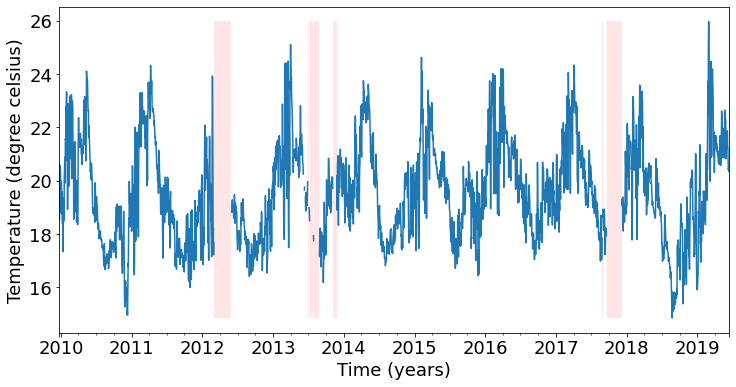

In [48]:
fig, ax = plt.subplots()
import matplotlib.transforms as mtransforms
temp_df_245_wgaps.TEMP.plot(ax = ax, figsize=(12,6))
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(temp_df_245_wgaps.index, temp_df_245_wgaps.TEMP.min(), temp_df_245_wgaps.TEMP.max(), where=np.isnan(temp_df_245_wgaps.TEMP),
                facecolor='red', alpha=0.1)
plt.ylabel("Temperature (degree celsius)")
plt.xlabel("Time (years)")

Text(0.5, 0, 'Time (years)')

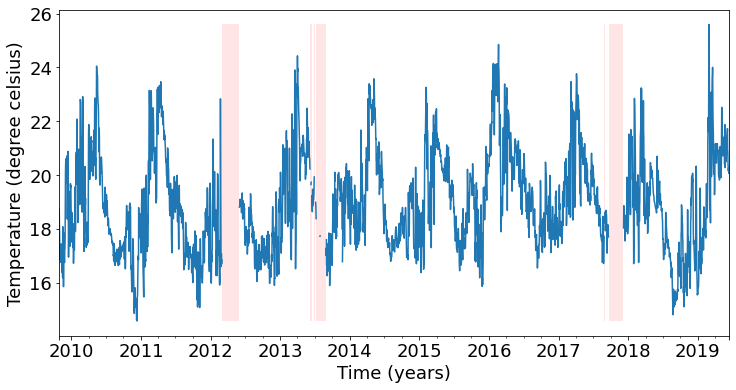

In [49]:
fig, ax = plt.subplots()
import matplotlib.transforms as mtransforms
temp_df_325_wgaps.TEMP.plot(ax = ax, figsize=(12,6))
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(temp_df_325_wgaps.index, temp_df_325_wgaps.TEMP.min(), temp_df_325_wgaps.TEMP.max(), where=np.isnan(temp_df_325_wgaps.TEMP),
                facecolor='red', alpha=0.1)
plt.ylabel("Temperature (degree celsius)")
plt.xlabel("Time (years)")

In [6]:
def gap_loc_and_len(sample):
    tmp = 0
    loc = []
    leng = []
    for i in range(len(sample)):
        current=sample[i]
        if not(np.isnan(current)) and tmp>0:
            leng.append(tmp)
            tmp=0
        if np.isnan(current):
            if (tmp==0) : loc.append(i)
            tmp=tmp+1
    df = pd.DataFrame({'location': loc,
                       'length': leng})
    return(df)

In [51]:
gaps = gap_loc_and_len(temp_df_245_wgaps.TEMP.values)
gaps

,location,length
0,799,91
1,1262,4
2,1268,3
3,1284,6
4,1294,19
5,1315,29
6,1414,21
7,2805,2
8,2827,79


In [52]:
gaps = gap_loc_and_len(temp_df_325_wgaps.TEMP.values)
gaps

,location,length
0,854,91
1,1317,4
2,1323,3
3,1330,1
4,1339,6
5,1349,19
6,1370,29
7,1401,1
8,1448,1
9,1485,1


## Models

In [6]:
class descaled_mape(keras.losses.Loss):
    """
    A loss/metric that (de)scales true and predicted values into absolute units before calculating mean absolute percentage error (mape).
    Args:
        mu: mean (usually training data mean)
        sd: standard dev (usually based on training data)
        reduction: Type of tf.keras.losses.Reduction to apply to loss.
        name: name of loss function
    """
    def __init__(self, mu, sd, reduction=keras.losses.Reduction.AUTO, name='descaled_mape'):
        super().__init__(reduction=reduction, name=name)
        self.mu=mu
        self.sd=sd
    
    def call(self, y_true, y_pred):
        y_true = y_true * self.sd + self.mu
        y_pred = y_pred * self.sd + self.mu
        return tf.math.reduce_mean(tf.abs((y_true - y_pred)/y_true))
    
def gap_loc_and_len(sample):
    tmp = 0
    loc = []
    leng = []
    for i in range(len(sample)):
        current=sample[i]
        if not(np.isnan(current)) and tmp>0:
            leng.append(tmp)
            tmp=0
        if np.isnan(current):
            if (tmp==0) : loc.append(i)
            tmp=tmp+1
    df = pd.DataFrame({'location': loc,
                       'length': leng})
    return(df)

def gapfill(samp, lstm_model, train_mean, train_std, hist_len, pred_len, gaps = pd.DataFrame(), scale=True):
    if gaps.empty: gaps = gap_loc_and_len(samp.TEMP)
    for i in range(len(gaps)):
        gap_start = gaps.location[i]
        gap_length = gaps.length[i]
        hist_end = gap_start
        if gap_start < hist_len:
            hist_start = 0
        else:
            hist_start = gap_start - hist_len
        if ((gap_start >= hist_len) and (not np.any(np.isnan(samp.TEMP[hist_start: hist_end]))) and (gap_length <= pred_len)):
            # create history array of shape (1, 30, 1) ending at gap_start
            history = np.reshape(samp.TEMP.values[:gap_start][-hist_len:], (1,hist_len,1))
            # scale history
            if (scale): history = (history - train_mean)/train_std
            # use model to predict based on history and fill in sample gap
            # descale model output
            out = lstm_model.predict(history)[0,:gap_length]
            if (scale): out = out * train_std + train_mean
            samp.TEMP[gap_start : (gap_start + gap_length)] = out
    return samp

In [54]:
# callbacks
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('loss: {:7.4f}, val_loss: {:7.4f}' .format(logs['loss'], logs['val_loss']))
    print('.', end='')
    # Create a callback that saves the model's weights
    
# early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20) # original model patience: 20 # dropout models patience: 40

In [55]:
# Model 1 to fill in gaps up to 10 days long
hist_len = 30
targ_len = 6

In [56]:
Time_diff = temp_df_245.index.to_series().diff()
break_index = np.where(Time_diff > pd.Timedelta(days=1))[0] - 1
break_index = np.append(break_index, len(temp_df_245))
window_len = hist_len + targ_len

In [60]:
data = []
labels = []
break_index = np.where(Time_diff > pd.Timedelta(days=1))[0] - 1 
window_len = hist_len + targ_len
for w in range(len(break_index)):
    run_start = hist_len if w == 0 else break_index[w-1] + 1 + hist_len
    run_end = break_index[w] - targ_len   
    for i in range(run_start, run_end):
        indices = range(i-hist_len, i)
        data.append(np.reshape(temp_df_325.TEMP.values[indices], (hist_len,1)))
        labels.append(temp_df_245.TEMP.values[i:i+targ_len])        
data = np.array(data)
labels = np.array(labels)
# Split into training and test datasets
trainidx = np.random.choice(len(data), int(np.round(0.9*len(data))), replace=False)
train_data = data[trainidx]
train_labels = labels[trainidx]
train_labels = train_labels.reshape((len(train_labels),targ_len))
val_data = np.delete(data, obj=trainidx, axis=0)
val_labels = np.delete(labels, trainidx, axis=0)
val_labels = val_labels.reshape((len(val_labels), targ_len))
# Normalisation
train_mean = train_data.mean()
train_std = train_data.std()
# save training, validation and normalisation data
pickle_out = open("../data/temp_depth_gapfilling_extended/depth_325/train_mean-std_train-val_data-labels_hist30_targ6.pickle", "wb")
pickle.dump([train_mean, train_std, train_data, train_labels, val_data, val_labels], pickle_out)
pickle_out.close()
train_data = (train_data-train_mean)/train_std
train_labels = (train_labels-train_mean)/train_std
val_data = (val_data-train_mean)/train_std
val_labels = (val_labels-train_mean)/train_std

In [62]:
BATCH_SIZE = 8
BUFFER_SIZE = data.shape[0]
train_univariate = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_univariate = train_univariate.cache().batch(BATCH_SIZE).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()
bidirectional_lstm_targ6_model = tf.keras.models.Sequential([
    layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=train_data.shape[-2:])),
    layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True,)),
    layers.Bidirectional(tf.keras.layers.LSTM(8, activation='relu')),
    tf.keras.layers.Dense(6)
])
bidirectional_lstm_targ6_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])
# checkpoints to save training progress
checkpoint_path = "../data/temp_depth_gapfilling_extended/bidirectional_lstm_daily_hist30_targ6_loss-descaledmape/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# callbacks
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

In [63]:
# Model 1 Training
STEPS = int(train_data.shape[0]/BATCH_SIZE)
VAL_STEPS = int(val_data.shape[0]/BATCH_SIZE)
EPOCHS = 500

history = bidirectional_lstm_targ6_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS,
                      validation_data=val_univariate, validation_steps=VAL_STEPS, verbose=0,
                 callbacks=[cp_callback, PrintDot(), es_callback])

loss:  0.0750, val_loss:  0.0745
..........loss:  0.0504, val_loss:  0.0532
..........loss:  0.0392, val_loss:  0.0425
..........loss:  0.0329, val_loss:  0.0380
..........loss:  0.0271, val_loss:  0.0321
..........loss:  0.0250, val_loss:  0.0273
..........loss:  0.0221, val_loss:  0.0249
..........loss:  0.0205, val_loss:  0.0228
..........loss:  0.0194, val_loss:  0.0218
..........loss:  0.0185, val_loss:  0.0209
..........loss:  0.0180, val_loss:  0.0209
..........loss:  0.0172, val_loss:  0.0213
..........loss:  0.0166, val_loss:  0.0211
..........loss:  0.0157, val_loss:  0.0197
..........loss:  0.0163, val_loss:  0.0191
........

In [64]:
# save history and model
pickle_out = open("../data/temp_depth_gapfilling_extended/bidirectional_lstm_model_hist30_targ6_loss-descaledmape_earlystopping_history.pickle", "wb")
pickle.dump(pd.DataFrame(history.history), pickle_out)
pickle_out.close()
## Save model
bidirectional_lstm_targ6_model.save('../data/temp_depth_gapfilling_extended/saved_models/bidirectional_lstm_model_hist30_targ6_loss-descaledmape.h5')